In [1]:
import cvxpy as cp
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import time

jnp.set_printoptions(suppress=True)
plt.rcParams['font.size'] = 20

# Our Method

In [2]:
def calc_da_alloc(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    num_g = len(mc_g_i)
    num_d = len(mv_d_j)

    # Define the variables
    g_i = [cp.Variable() for i in range(num_g)]
    d_j = [cp.Variable() for j in range(num_d)]

    # Define the objective
    objective = cp.Minimize(sum(mc_g_i[i] * g_i[i] for i in range(num_g)) - sum(mv_d_j[j] * d_j[j] for j in range(num_d)))

    # Define the constraints
    constraints = [
                    sum(d_j[j] for j in range(num_d)) == sum(g_i[i] for i in range(num_g))
                ] + [
                    g_i[i] >= 0 for i in range(num_g)
                ] + [
                    g_i[i] <= sum(g_i_bar[p][i] * probs[p] for p in range(len(probs))) for i in range(num_g)
                ] + [
                    d_j[j] >= 0 for j in range(num_d)
                ] + [
                    d_j[j] <= sum(d_j_bar[p][j] * probs[p] for p in range(len(probs))) for j in range(num_d)
                ]

    # Define the problem and solve it
    prob = cp.Problem(objective, constraints)
    prob.solve()

    g_i_jax = jnp.array([g_i[i].value for i in range(num_g)])
    d_j_jax = jnp.array([d_j[j].value for j in range(num_d)])

    return g_i_jax, d_j_jax

In [3]:
# `g_i_bar` and `d_j_bar` are just a single scenario (row)
def calc_rt_alloc(mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    num_g = len(mc_g_i)
    num_d = len(mv_d_j)

    # Define the variables
    g_i = [cp.Variable() for i in range(num_g)]
    d_j = [cp.Variable() for j in range(num_d)]

    # Define the objective
    objective = cp.Minimize(sum(mc_g_i[i] * g_i[i] for i in range(num_g)) - sum(mv_d_j[j] * d_j[j] for j in range(num_d)))

    # Define the constraints
    constraints = [
                    sum(d_j[j] for j in range(num_d)) == sum(g_i[i] for i in range(num_g))
                ] + [
                    g_i[i] >= 0 for i in range(num_g)
                ] + [
                    g_i[i] <= g_i_bar[i] for i in range(num_g)
                ] + [
                    d_j[j] >= 0 for j in range(num_d)
                ] + [
                    d_j[j] <= d_j_bar[j] for j in range(num_d)
                ]

    # Define the problem and solve it
    prob = cp.Problem(objective, constraints)
    prob.solve()
    g_i_jax = jnp.array([g_i[i].value for i in range(num_g)])
    d_j_jax = jnp.array([d_j[j].value for j in range(num_d)])

    return g_i_jax, d_j_jax

In [4]:
# scenario_g_i has shape (num_g), scenario_d_j has shape (num_d)
def scenario_utility(scenario_g_i, scenario_d_j, pi, mc_g_i, mv_d_j):
    g_cur_u = jnp.sum(scenario_g_i * (pi - mc_g_i))
    d_cur_u = jnp.sum(scenario_d_j * (mv_d_j - pi))
    return g_cur_u + d_cur_u # scalar

v_util = jax.vmap(scenario_utility, in_axes=(0, 0, None, None, None))
def expected_utility(g_i, d_j, pi, mc_g_i, mv_d_j, probs):
    # change this to take `probs` into account or just pass in MC samples
    return jnp.dot(probs, v_util(g_i, d_j, pi, mc_g_i, mv_d_j))

da_grad_g = jax.grad(scenario_utility, argnums=0) # we want gradients of dimension (num_g)
da_grad_d = jax.grad(scenario_utility, argnums=1) # we want gradients of dimension (num_d)
da_grad_pi = jax.grad(expected_utility, argnums=2) # we want gradients of dimension ()

In [5]:
def da_ascent_descent(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar, alpha = 0.01, gamma = 0.9999, epochs = 2000, rounds_per_epoch = 10, convergence = None, plot = False):
    g_i = jnp.ones((len(probs), len(mc_g_i)))
    d_j = jnp.ones((len(probs), len(mv_d_j)))
    pi = 1.0

    @jax.jit
    def update(g_i, d_j, pi, alpha):
        def update_scenario(scenario_g_i, scenario_d_j, pi, alpha, scenario):
            scenario_g_i += alpha * da_grad_g(scenario_g_i, scenario_d_j, pi, mc_g_i, mv_d_j)
            scenario_d_j += alpha * da_grad_d(scenario_g_i, scenario_d_j, pi, mc_g_i, mv_d_j)

            scenario_g_i = jnp.clip(scenario_g_i, 0, g_i_bar[scenario])
            scenario_d_j = jnp.clip(scenario_d_j, 0, d_j_bar[scenario])

            return scenario_g_i, scenario_d_j

        g_i, d_j = jax.vmap(update_scenario, in_axes=(0, 0, None, None, 0))(g_i, d_j, pi, alpha, jnp.arange(len(probs)))
        # update prices by the mean gradient
        pi -= alpha * da_grad_pi(g_i, d_j, pi, mc_g_i, mv_d_j, probs)
        pi = jnp.clip(pi, 0)

        alpha *= gamma

        return g_i, d_j, pi, alpha

    pi_hist = [pi]
    g_hist = [g_i]
    d_hist = [d_j]

    for i in range(epochs * rounds_per_epoch):
        g_i, d_j, pi, alpha = update(g_i, d_j, pi, alpha)
        if i % rounds_per_epoch == 0:
            pi_hist.append(pi)
            g_hist.append(g_i)
            d_hist.append(d_j)

            previous_prices = pi_hist[-10:]
            if convergence and len(previous_prices) == 10 and abs(max(previous_prices) - min(previous_prices)) < convergence:
                break

    if plot:
        plt.figure(figsize=(20, 5))
        plt.plot(pi_hist, '-o')
        plt.xlabel('Iteration')
        plt.ylabel('Price')
        # not plotting allocations because they are already 2D

    # returning the allocations that have been modified through GDA
    return g_i, d_j, pi, i / rounds_per_epoch

In [6]:
def utility(g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    g_cur_u = jnp.sum(g_i * (pi - mc_g_i))
    d_cur_u = jnp.sum(d_j * (mv_d_j - pi))
    return g_cur_u + d_cur_u

rt_grad_g = jax.grad(utility, argnums=0)
rt_grad_d = jax.grad(utility, argnums=1)
rt_grad_pi = jax.grad(utility, argnums=2)

In [7]:
def rt_ascent_descent(mc_g_i, mv_d_j, g_i_bar, d_j_bar, alpha = 0.01, gamma = 0.9999, epochs = 2000, rounds_per_epoch = 10, convergence = None, plot = False):
    g_i = jnp.ones(len(mc_g_i))
    d_j = jnp.ones(len(mv_d_j))
    pi = 1.0

    @jax.jit
    def update(g_i, d_j, pi, alpha):
        g_i += alpha * rt_grad_g(g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar)
        d_j += alpha * rt_grad_d(g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar)
        pi -= alpha * rt_grad_pi(g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar)

        g_i = jnp.clip(g_i, 0, g_i_bar)
        d_j = jnp.clip(d_j, 0, d_j_bar)
        pi = jnp.clip(pi, 0)

        alpha *= gamma

        return g_i, d_j, pi, alpha

    pi_hist = [pi]
    g_hist = [g_i]
    d_hist = [d_j]

    for i in range(epochs * rounds_per_epoch):
        g_i, d_j, pi, alpha = update(g_i, d_j, pi, alpha)
        if i % rounds_per_epoch == 0:
            pi_hist.append(pi)
            g_hist.append(g_i)
            d_hist.append(d_j)

            previous_prices = pi_hist[-10:]
            if convergence and len(previous_prices) == 10 and abs(max(previous_prices) - min(previous_prices)) < convergence:
                break

    if plot:
        plt.figure(figsize=(20, 5))
        plt.plot(pi_hist, '-o')
        plt.xlabel('Iteration')
        plt.ylabel('Price')

        plt.figure(figsize=(20, 5))
        plt.plot(g_hist, '-o')
        plt.xlabel('Iteration')
        plt.ylabel('Generation')

        plt.figure(figsize=(20, 5))
        plt.plot(d_hist, '-o')
        plt.xlabel('Iteration')
        plt.ylabel('Demand')

    # returning the allocations that have been modified through GDA
    return g_i, d_j, pi, i / rounds_per_epoch

# Zavala's Method

In [8]:
def zavala(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    num_g = len(mc_g_i)
    num_d = len(mv_d_j)

    # Define the variables
    g_i = [cp.Variable() for i in range(num_g)]
    G_i = [[cp.Variable() for i in range(num_g)] for p in range(len(probs))]
    d_j = [cp.Variable() for j in range(num_d)]
    D_j = [[cp.Variable() for j in range(num_d)] for p in range(len(probs))]

    # Compute incremental bids (just a heuristic)
    mc_g_i_delta = mc_g_i / 10.0
    mv_d_j_delta = mv_d_j / 10.0

    # Define the objective
    objective = cp.Minimize(sum(sum((mc_g_i[i] * G_i[p][i] + mc_g_i_delta[i] * cp.max(cp.vstack([G_i[p][i] - g_i[i], 0])) + mc_g_i_delta[i] * cp.max(cp.vstack([g_i[i] - G_i[p][i], 0]))) * probs[p] for p in range(len(probs))) for i in range(num_g)) \
                            + sum(sum((-mv_d_j[j] * D_j[p][j] + mv_d_j_delta[j] * cp.max(cp.vstack([d_j[j] - D_j[p][j], 0])) + mv_d_j_delta[j] * cp.max(cp.vstack([D_j[p][j] - d_j[j], 0]))) * probs[p] for p in range(len(probs))) for j in range(num_d)))

    # Define the constraints
    day_ahead_balance = [
                    sum(d_j[j] for j in range(num_d)) == sum(g_i[i] for i in range(num_g))
                ]
    real_time_balance = [
                    sum(D_j[p][j] - d_j[j] for j in range(num_d)) == sum(G_i[p][i] - g_i[i] for i in range(num_g)) for p in range(len(probs))
                ]

    constraints = day_ahead_balance \
                + real_time_balance + [
                    G_i[p][i] >= 0 for p in range(len(probs)) for i in range(num_g)
                ] + [
                    G_i[p][i] <= g_i_bar[p][i] for p in range(len(probs)) for i in range(num_g)
                ] + [
                    D_j[p][j] >= 0 for p in range(len(probs)) for j in range(num_d)
                ] + [
                    D_j[p][j] <= d_j_bar[p][j] for p in range(len(probs)) for j in range(num_d)
                ]

    # Define the problem and solve it
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, eps=1e-6, max_iters=20000)

    g_i_jax = jnp.array([g_i[i].value for i in range(num_g)])
    d_j_jax = jnp.array([d_j[j].value for j in range(num_d)])
    G_i_jax = jnp.array([[G_i[p][i].value for i in range(num_g)] for p in range(len(probs))])
    D_j_jax = jnp.array([[D_j[p][j].value for j in range(num_d)] for p in range(len(probs))])
    pi = day_ahead_balance[0].dual_value
    Pi = jnp.array([real_time_balance[p].dual_value / probs[p] for p in range(len(probs))])

    return g_i_jax, d_j_jax, G_i_jax, D_j_jax, pi, Pi

# Cross-Evaluation

In [9]:
def generate_instance(key, num_scenarios = 10, num_g = 10, num_d = 10, minval = 1, maxval = 100):
    probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
    probs = random.dirichlet(probs_key, jnp.ones(num_scenarios))
    # probs = jnp.ones(num_scenarios) / num_scenarios
    mc_g_i = random.uniform(mc_key, (num_g,), minval=minval, maxval=maxval)
    mv_d_j = random.uniform(mv_key, (num_d,), minval=minval, maxval=maxval)
    g_i_bar = random.uniform(g_key, (num_scenarios, num_g), minval=minval, maxval=maxval)
    d_j_bar = random.uniform(d_key, (num_scenarios, num_d), minval=minval, maxval=maxval)
    return probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar

In [10]:
def price_distortion(probs, pi, Pi):
    return abs(pi - sum(probs * Pi))

# allows some error!
def feasible(g_i, d_j, scenario_g_i_bar, scenario_d_j_bar):
    return jnp.all(g_i <= scenario_g_i_bar + 0.1) and jnp.all(d_j <= scenario_d_j_bar + 0.1)

def probability_feasible(probs, g_i, d_j, g_i_bar, d_j_bar):
    # sum up probs where g_i <= g_i_bar[p] and d_j <= d_j_bar[p]
    probability_sum = 0
    for p in range(len(probs)):
        if feasible(g_i, d_j, g_i_bar[p], d_j_bar[p]):
            probability_sum += probs[p]
    return probability_sum

def welfare(g_i, d_j, mc_g_i, mv_d_j, scenario_g_i_bar, scenario_d_j_bar):
    if feasible(g_i, d_j, scenario_g_i_bar, scenario_d_j_bar):
        return jnp.sum(mv_d_j * d_j) - jnp.sum(mc_g_i * g_i)
    else:
        return None

def expected_welfare(probs, g_i, d_j, mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    # assume infeasible scenarios have zero welfare!
    expected_welfare = 0
    for p in range(len(probs)):
        welfare = welfare(g_i, d_j, mc_g_i, mv_d_j, g_i_bar[p], d_j_bar[p])
        if welfare is not None:
            expected_welfare += probs[p] * welfare
    return expected_welfare

def cumulative_regret(g_i, d_j, pi, mc_g_i, mv_d_j, scenario_g_i_bar, scenario_d_j_bar):
    if feasible(g_i, d_j, scenario_g_i_bar, scenario_d_j_bar):
        g_ind_u = jnp.sum(scenario_g_i_bar * jnp.maximum(pi - mc_g_i, 0))
        g_cur_u = jnp.sum(g_i * (pi - mc_g_i))
        d_ind_u = jnp.sum(scenario_d_j_bar * jnp.maximum(mv_d_j - pi, 0))
        d_cur_u = jnp.sum(d_j * (mv_d_j - pi))
        return (g_ind_u - g_cur_u) + (d_ind_u - d_cur_u)
    else:
        return None

def expected_cumulative_regret(probs, g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar):
    # assume infeasible scenarios have zero regret!
    expected_regret = 0
    for p in range(len(probs)):
        regret = cumulative_regret(g_i, d_j, pi, mc_g_i, mv_d_j, g_i_bar[p], d_j_bar[p])
        if regret is not None:
            expected_regret += probs[p] * regret
    return expected_regret

In [11]:
num_instances = 10
key = random.key(2)
keys = random.split(key, num_instances)
instances = []
for key in keys:
    instances.append(generate_instance(key, num_scenarios=10, num_g=10, num_d=10))

zavala_times = []
zavala_distortions = []
zavala_regrets = []
our_times = []
our_distortions = []
our_regrets = []
# our_epochs = []
probs_feasible = []

for i in range(len(instances)):
    print('Instance', i)
    probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar = instances[i]

    start_time = time.time()
    z_g_i, z_d_j, _, _, z_pi, z_Pi = zavala(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar)
    end_time = time.time()
    probs_feasible.append(probability_feasible(probs, z_g_i, z_d_j, g_i_bar, d_j_bar))
    zavala_times.append(end_time - start_time)
    print(end_time - start_time)
    zavala_distortions.append(price_distortion(probs, z_pi, z_Pi))
    zavala_regrets.append(expected_cumulative_regret(probs, z_g_i, z_d_j, z_pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))

    start_time = time.time()
    _, _, pi, epochs = da_ascent_descent(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar,
                                 alpha = 0.01, gamma = 0.9999, epochs = 3000, rounds_per_epoch = 10,
                                 convergence = None, plot = False)
    # our_epochs.append(epochs)
    end_time = time.time()
    our_times.append(end_time - start_time)
    print(end_time - start_time)
    Pi = []
    for p in range(len(probs)):
        # calculate RT allocation and prices
        _, _, Pi_next, epochs = rt_ascent_descent(mc_g_i, mv_d_j, g_i_bar[p], d_j_bar[p],
                                                  alpha = 0.01, gamma = 0.9999, epochs = 1500, rounds_per_epoch = 10,
                                                  convergence = None, plot = False)
        Pi.append(Pi_next)
    Pi = jnp.array(Pi)
    our_distortions.append(price_distortion(probs, pi, Pi))
    our_regrets.append(expected_cumulative_regret(probs, z_g_i, z_d_j, pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))

print(f'Mean prob feasible: {np.mean(probs_feasible)}')
print(f'Zavala mean time: {np.mean(zavala_times)}')
print(f'Our mean time: {np.mean(our_times)}')
print(f'Zavala mean distortion: {np.mean(zavala_distortions)}')
print(f'Our mean distortion: {np.mean(our_distortions)}')
print(f'Zavala mean regret: {np.mean(zavala_regrets)}')
print(f'Our mean regret: {np.mean(our_regrets)}')
# print(f'Our mean epochs: {np.mean(our_epochs)}')
print("pi:", float(pi), "Pi mean:", float(jnp.sum(probs*Pi)), "Pi min/max:", float(Pi.min()), float(Pi.max()))

Instance 0


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7747042179107666
0.42673420906066895
Instance 1


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.6767182350158691
0.3865342140197754
Instance 2


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.683678150177002
0.39026880264282227
Instance 3


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7222049236297607
0.39609479904174805
Instance 4


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7488760948181152
0.3962059020996094
Instance 5


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7290852069854736
0.40485596656799316
Instance 6


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.578092098236084
0.3853273391723633
Instance 7


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7322356700897217
0.388261079788208
Instance 8


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.664686918258667
0.38701295852661133
Instance 9


/opt/anaconda3/envs/electricity_markets/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


0.7709178924560547
0.39122915267944336
Mean prob feasible: 0.0882101148366928
Zavala mean time: 0.7081199407577514
Our mean time: 0.3952524423599243
Zavala mean distortion: 0.1551586091518402
Our mean distortion: 3.2332050800323486
Zavala mean regret: 132.79507122039794
Our mean regret: 130.83474359214307
pi: 48.161319732666016 Pi mean: 44.925819396972656 Pi min/max: 35.88230895996094 62.93840408325195


1653.0
1453.0


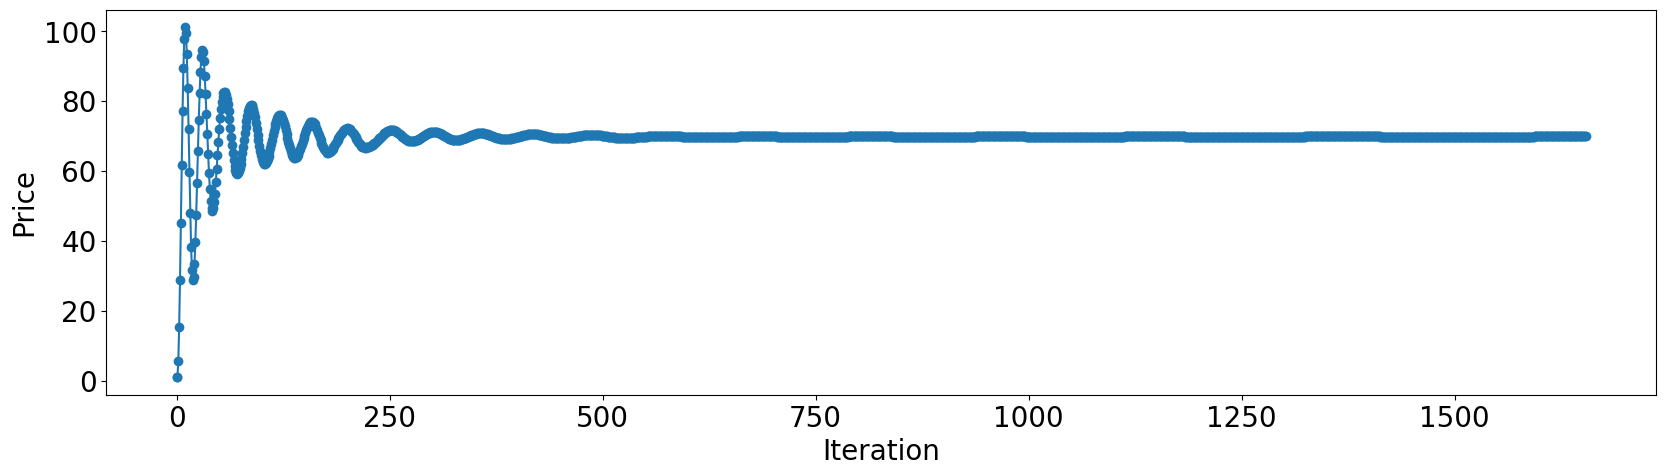

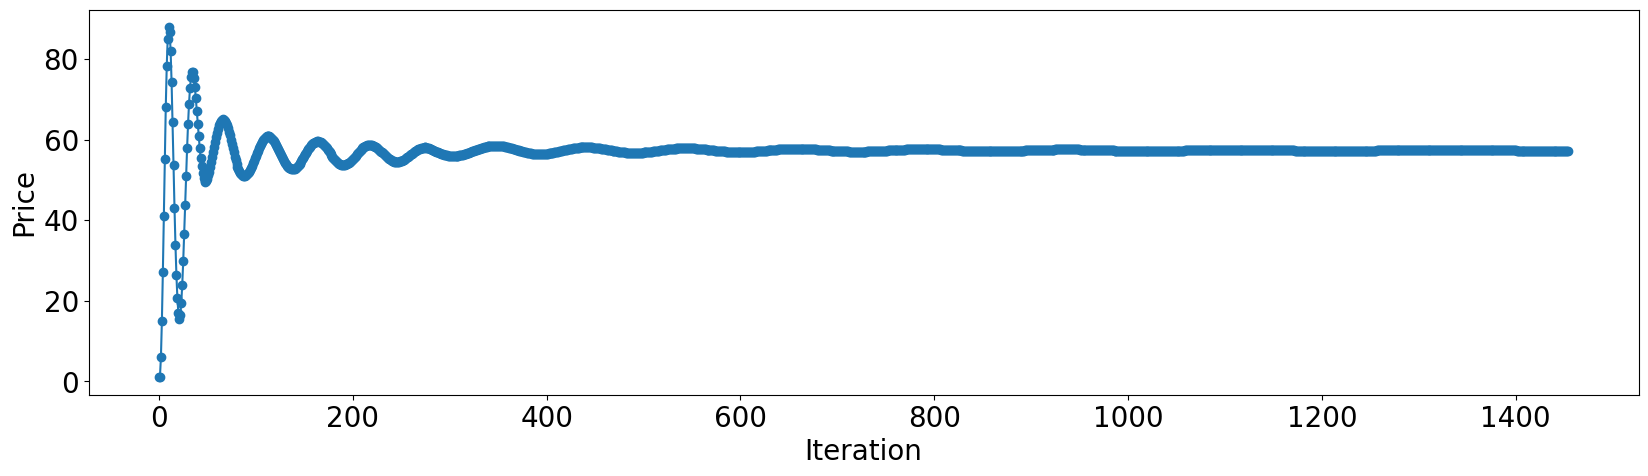

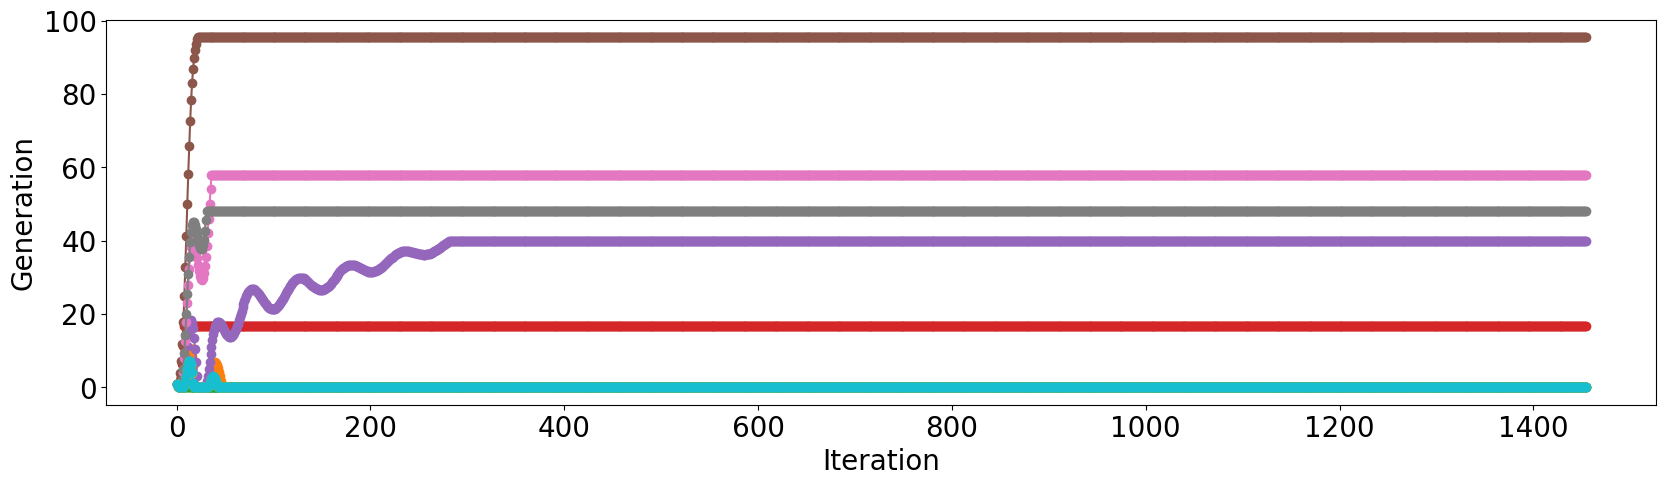

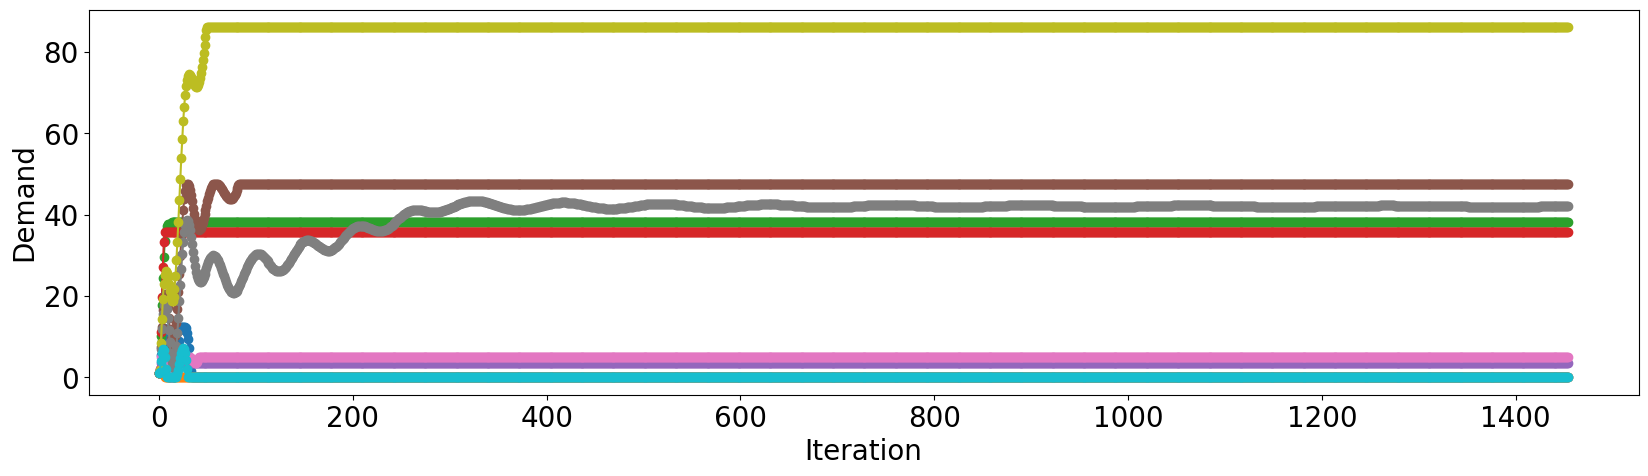

In [12]:
key = random.key(57)
probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar = generate_instance(key, num_scenarios=3, num_g=10, num_d=10)
_, _, pi, epochs = da_ascent_descent(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar,
                                    alpha = 0.01, gamma = 0.9999, epochs = 4000, rounds_per_epoch = 10,
                                    convergence = 0.001, plot = True)
print(epochs)
_, _, pi, epochs = rt_ascent_descent(mc_g_i, mv_d_j, g_i_bar[0], d_j_bar[0],
                                    alpha = 0.01, gamma = 0.9999, epochs = 4000, rounds_per_epoch = 10,
                                    convergence = 0.001, plot = True)
print(epochs)